# Experiment 2: Building Neural Networks from Scratch

Objective:
- Implement a single neuron for AND gate and verify it
- Extend to a Feedforward Neural Network (FFNN) for XOR/AND
- Implement a simple MLP to solve a slightly more complex dataset

We’ll work step-by-step, keeping the code simple and clear.

## 1) Install and Import Libraries
We install and import only what we need. If running in a managed environment, the install step can be skipped if already available.

In [1]:
# If packages are missing, uncomment the next line to install
# %pip install numpy matplotlib seaborn scipy scikit-learn pandas

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.datasets import make_moons
from sklearn.dummy import DummyClassifier
import pandas as pd

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context('notebook')

## 2) Single Neuron for AND Gate
We implement a perceptron with a step activation to model the AND truth table.

In [2]:
# Perceptron with step activation for AND

def step(x):
    return (x >= 0).astype(int)

# We can hand-pick weights for AND: output 1 only when both inputs are 1
W = np.array([[1.0], [1.0]])  # weights
b = -1.5                        # bias (threshold)

X_and = np.array([[0,0], [0,1], [1,0], [1,1]])
y_and_true = np.array([[0], [0], [0], [1]])

logits = X_and @ W + b
preds = step(logits)

# Show truth table
and_table = pd.DataFrame(np.hstack([X_and, preds]), columns=['x1','x2','AND_pred'])
print(and_table)
assert (preds == y_and_true).all(), "AND perceptron failed truth table"
print("AND perceptron verified ✔")

   x1  x2  AND_pred
0   0   0         0
1   0   1         0
2   1   0         0
3   1   1         1
AND perceptron verified ✔


## 3) FFNN for XOR and AND
A single perceptron cannot compute XOR. We’ll build a tiny 2-layer FFNN that can produce XOR and AND.

In [3]:
# Tiny FFNN with step activations to realize XOR and AND
# Architecture: 2 inputs -> 2 hidden neurons -> 2 outputs (XOR, AND)
# Hidden computes [OR, AND]; outputs combine to form [XOR, AND].

X_bool = X_and.copy()

# Hidden layer: OR and AND using step(x>=0)
# z_or = x1 + x2 - 0.5  -> OR
# z_and = x1 + x2 - 1.5 -> AND
W1 = np.array([[1, 1],
               [1, 1]], dtype=float)   # shape (2,2)
b1 = np.array([[-0.5, -1.5]], dtype=float)

# Output layer:
# XOR = step(1*OR + (-2)*AND - 0.5)
# AND = step(0*OR + 1*AND - 0.5)
W2 = np.array([[ 1, 0],
               [-2, 1]], dtype=float)   # shape (2,2)
b2 = np.array([[-0.5, -0.5]], dtype=float)

def ff_step_net(X):
    h = step(X @ W1 + b1)      # hidden: [OR, AND]
    o = step(h @ W2 + b2)      # outputs: [XOR, AND]
    return h, o

h, o = ff_step_net(X_bool)

xor_true = np.array([[0],[1],[1],[0]])
and_true = np.array([[0],[0],[0],[1]])

ff_table = pd.DataFrame(np.hstack([X_bool, o]), columns=['x1','x2','XOR_pred','AND_pred'])
print(ff_table)
assert (o[:,[0]] == xor_true).all(), "XOR output incorrect"
assert (o[:,[1]] == and_true).all(), "AND output incorrect"
print("FFNN XOR and AND verified ✔")

   x1  x2  XOR_pred  AND_pred
0   0   0         0         0
1   0   1         1         0
2   1   0         1         0
3   1   1         0         1
FFNN XOR and AND verified ✔


## 4) MLP on a Simple Dataset
We now build and train a small NumPy MLP on a 2D dataset and visualize performance.

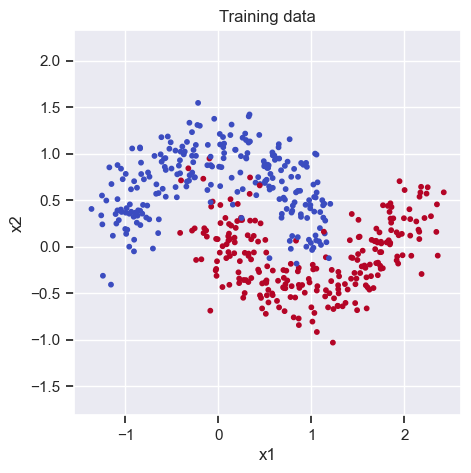

In [4]:
# Generate a 2D dataset (moons) and split
X, y = make_moons(n_samples=600, noise=0.2, random_state=42)
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

plt.figure(figsize=(5,5))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train.flatten(), cmap='coolwarm', s=10)
plt.title('Training data'); plt.xlabel('x1'); plt.ylabel('x2'); plt.axis('equal')
plt.show()


Epoch 50 loss 0.3368
Epoch 100 loss 0.3076
Epoch 150 loss 0.2954
Epoch 200 loss 0.2879
Test Accuracy: 0.883


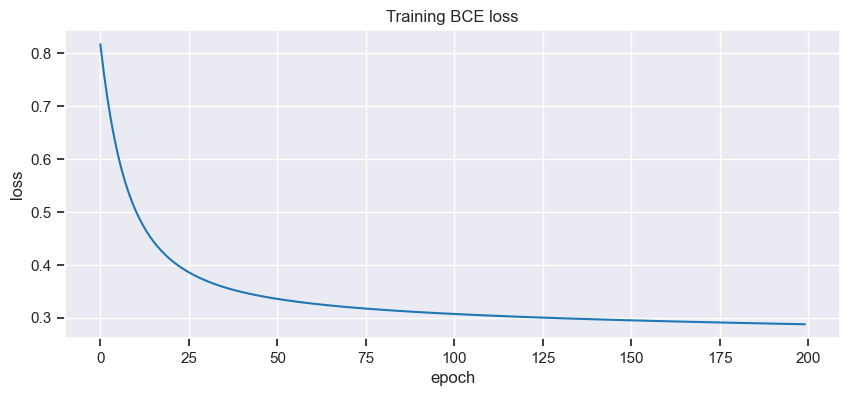

In [5]:
# Simple NumPy MLP (1 hidden layer) for binary classification

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def bce(y_true, y_pred, eps=1e-12):
    y_pred = np.clip(y_pred, eps, 1-eps)
    return -np.mean(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

class SimpleMLP:
    def __init__(self, input_dim, hidden=16, lr=0.1, l2=0.0):
        self.lr = lr; self.l2 = l2
        self.W1 = np.random.randn(input_dim, hidden) * np.sqrt(2/input_dim)
        self.b1 = np.zeros((1, hidden))
        self.W2 = np.random.randn(hidden, 1) * np.sqrt(2/hidden)
        self.b2 = np.zeros((1, 1))
    def forward(self, X):
        z1 = X @ self.W1 + self.b1
        a1 = np.maximum(0, z1)
        z2 = a1 @ self.W2 + self.b2
        yhat = sigmoid(z2)
        return yhat, {"X":X, "z1":z1, "a1":a1, "z2":z2, "yhat":yhat}
    def loss(self, y, yhat):
        return bce(y, yhat) + 0.5*self.l2*(np.sum(self.W1**2)+np.sum(self.W2**2))
    def backward(self, cache, y):
        X, a1, yhat = cache["X"], cache["a1"], cache["yhat"]
        m = X.shape[0]
        dz2 = (yhat - y)/m
        dW2 = a1.T @ dz2 + self.l2*self.W2
        db2 = np.sum(dz2, axis=0, keepdims=True)
        da1 = dz2 @ self.W2.T
        dz1 = da1 * (cache["z1"] > 0)
        dW1 = X.T @ dz1 + self.l2*self.W1
        db1 = np.sum(dz1, axis=0, keepdims=True)
        self.W2 -= self.lr*dW2; self.b2 -= self.lr*db2
        self.W1 -= self.lr*dW1; self.b1 -= self.lr*db1
    def predict(self, X):
        yhat,_ = self.forward(X)
        return (yhat>=0.5).astype(int)

mlp = SimpleMLP(input_dim=2, hidden=24, lr=0.1, l2=1e-4)

epochs = 200
train_losses = []
for ep in range(1, epochs+1):
    yhat, cache = mlp.forward(X_train)
    loss = mlp.loss(y_train, yhat)
    mlp.backward(cache, y_train)
    train_losses.append(loss)
    if ep % 50 == 0:
        print(f"Epoch {ep} loss {loss:.4f}")

# Evaluate
preds = mlp.predict(X_test)
acc = (preds == y_test).mean()
print(f"Test Accuracy: {acc:.3f}")

plt.figure(figsize=(10,4))
plt.plot(train_losses)
plt.title('Training BCE loss'); plt.xlabel('epoch'); plt.ylabel('loss')
plt.show()


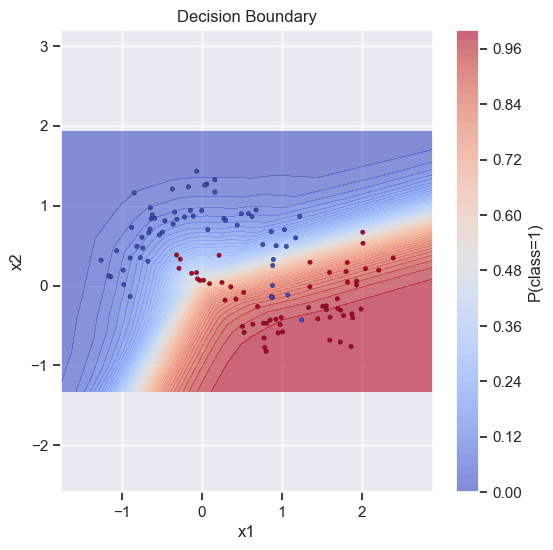

In [6]:
# Decision boundary plot

def plot_decision_boundary(model, X, y, steps=300):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps), np.linspace(y_min, y_max, steps))
    grid = np.c_[xx.ravel(), yy.ravel()]
    yhat,_ = model.forward(grid)
    Z = yhat.reshape(xx.shape)
    plt.figure(figsize=(6,6))
    plt.contourf(xx, yy, Z, levels=50, cmap='coolwarm', alpha=0.6)
    plt.colorbar(label='P(class=1)')
    plt.scatter(X[:,0], X[:,1], c=y.flatten(), cmap='coolwarm', s=10, edgecolor='k', linewidth=0.2)
    plt.title('Decision Boundary'); plt.xlabel('x1'); plt.ylabel('x2'); plt.axis('equal')
    plt.show()

plot_decision_boundary(mlp, X_test, y_test)
